In [82]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from IPython.display import clear_output

In [83]:
class Block:
    '''
    Takes on a position to be on a board
    Attributes:
    dir = direction it tells the car to move, can me up, lup (meaning left turn from upward lane), rup (meaning right turn from upward lane), but for all 4 directions.
    _is_intersection = tells cars to only listen to their previoulsy dirven direction if on an intersection square
    __is_left_turn_lane = block in where the left turns happen
    _is_right_turn_lane = block in where the right turns happen
    _occupied = stores if a car is already on that block
    _blocked = stores if a car can't move to a square because of traffic signal or closure
    turn_checker = when a car passes this block, it rolls to decide if it will be turning at the next intersection
    turn_forcer = making cars that would be going into a closed off road instead turn

    Methods:
    All methods are either assigning or returning an attribute.
     '''
    def __init__(self, row: int, col: int):
        self.row = int(row)
        self.col = int(col)
        self.dir = "null"
        self.is_intersection = False
        self.is_left_turn_lane = False
        self.is_right_turn_lane = False
        self.allowed_turns = {"left": False, "right": False, "straight": False}
        self._occupied = False
        self._blocked = False
        self.turn_checker = False
        self.turn_forcer = False


    def set_blocked(self, flag: bool):
        self._blocked = bool(flag)

    def ret_blocked(self) -> bool:
        return self._blocked
    def set_main_dir(self, direction: str):
        self.dir = direction
        # by default straight allowed
        self.allowed_turns["straight"] = True
    def set_turn_force(self):
        self.turn_forcer = True

    def set_turn_check(self, boo):
        self.turn_checker = boo #used to create lane merge
        
    def set_intersection(self): #outdated but don't want to edit other parts rn
        self.is_intersection = True
        
    def set_left_turn_lane(self):
        self.is_left_turn_lane = True

    def set_right_turn_lane(self): #outdated but don't want to edit other parts rn
        self.is_right_turn_lane = True

    def set_occupied(self, flag: bool): #stops a car for going on a square. Used for both traffic signals, congestion, and eventually road blocks
        self._occupied = bool(flag)

    def ret_dir(self): #Way to call on direction to decide how the car will move
        return self.dir

    def ret_occupation(self): #check if car can move to that square
        return self._occupied
        
    def ret_right_turn_lane(self):#check if cell is a right turn lane
        return self.is_right_turn_lane
        
    def ret_is_intersection(self): #outdated but don't want to edit other parts rn
        return self.is_intersection

    def ret_allowed_turns(self): #outdated but don't want to edit other parts rn
        return self.allowed_turns

In [93]:
# Making the board----------------------------
def board_init(n: int):#square array of road cells. Best result for odd n >= 81
    '''
    Takes on a number to make a nxn board of the Block class
    '''
    board = []
    for r in range(n):
        row = []
        for c in range(n):
            row.append(Block(row=r, col=c))
        board.append(row)
    return board


def init_roads(board):
    '''
    This is where everything important for the blocks on the board happens. 
    Roads, turning lanes, intersections, and some default check cases for future functions all get initialized here.
    '''
    n = len(board)
    if n == 0:
        return
    m = n // 2 #middle lane of square
    board[0][0].set_occupied(True) #Used as default check square in spawning car function
    board[m][m].set_left_turn_lane() #helpful visual for where the middle of the board is considered in case of bugs
    uproads    = [m-21, m-20, m-6,  m-5,  m+9,  m+10, m+24, m+25] #relative index to middle of array. Best for odd n >= 81
    downroads  = [m-24, m-23, m-9,  m-8,  m+6,  m+7,  m+21, m+22]
    rightroads = [m-21, m-20, m-6,  m-5,  m+9,  m+10, m+24, m+25]
    leftroads  = [m-24, m-23, m-9,  m-8,  m+6,  m+7,  m+21, m+22]

    left_turn_cols = [m-22, m-7, m+8, m+23] #in between lanes of the roads
    offset = [4,5,6,7] #cell offset to create left turn lanes

    for r in rightroads: #initializes the right-bound lanes
        if 0 <= r < n:
            for c in range(n):
                board[r][c].set_main_dir("right") 
    for r in leftroads: #initializes the left-bound lanes
        if 0 <= r < n:
            for c in range(n):
                board[r][c].set_main_dir("left")

    for c in uproads: #initializes the upward-bound lanes
        if 0 <= c < n:
            for r in range(n):
                if board[r][c].ret_dir() in ("left", "right"): #Creates intersection blocks if overriding horizontal road
                    board[r][c].set_intersection()
                else:
                    board[r][c].set_main_dir("up")
    for c in downroads: #initializes the downward-bound lanes
        if 0 <= c < n:
            for r in range(n):
                if board[r][c].ret_dir() in ("left", "right"): #Creates intersection blocks if overriding horizontal road
                    board[r][c].set_intersection()
                else:
                    board[r][c].set_main_dir("down")
    for c in left_turn_cols: #happens after road initializationso right turns aren't overwritten
        for d in left_turn_cols: #Happening based off middle cell of every intersection
            #Make left turns
            board[c-3][d].set_left_turn_lane()#Makes those purple squares cause left turns
            board[c+3][d].set_left_turn_lane()
            board[c][d-3].set_left_turn_lane()
            board[c][d+3].set_left_turn_lane()
            board[c-3][d].set_main_dir("ldown") #way of doing previous 4 lines to decide movement
            board[c+3][d].set_main_dir("lup")
            board[c][d-3].set_main_dir("lright")
            board[c][d+3].set_main_dir("lleft")
            board[c+8][d+1].set_turn_check(True)#left lane merge for each direction
            board[c-8][d-1].set_turn_check(True)
            board[c+1][d-8].set_turn_check(True)
            board[c-1][d+8].set_turn_check(True)
            #Make right turns
            board[c-3][d-2].set_right_turn_lane()#down,up,right,left
            board[c+3][d+2].set_right_turn_lane()
            board[c+2][d-3].set_right_turn_lane()
            board[c-2][d+3].set_right_turn_lane()
            board[c-3][d-2].set_main_dir("rdown") #way of doing previous 4 lines to decide movement
            board[c+3][d+2].set_main_dir("rup")
            board[c+2][d-3].set_main_dir("rright")
            board[c-2][d+3].set_main_dir("rleft")
            board[c-3][d-2].set_turn_check(True) #will try a turn check on cell before as well
            board[c+3][d+2].set_turn_check(True)
            board[c+2][d-3].set_turn_check(True)
            board[c-2][d+3].set_turn_check(True)
            #Gaps in between lanes that will become left-turn lanes
            for diff in offset:
                board[c+diff][d].set_main_dir("up") #Creates the straight-aways up to the left turn
                board[c-diff][d].set_main_dir("down")
                board[c][d-diff].set_main_dir("right")
                board[c][d+diff].set_main_dir("left")
    turn_forcers = [(m-8,m+32),(m-9,m+26),(m-25,m+6),(m-31,m+7),(m-5,m-10),(m-6,m-16),(m+11,m+10),(m+16,m+9)]
    for tup in turn_forcers:
        board[tup[0]][tup[1]].set_turn_force()
    removed_turns = [(m-22,m+16),(m-20,m+5),(m-15,m-8),(m-4,m-5),(m+9,m),(m+6,m+11),(m+1,m+24),(m-10,m+21)]
    for tup in removed_turns:
        board[tup[0]][tup[1]].set_turn_check(False)


In [94]:
class Car: #right turns not set up currently, but very easy implement
    '''
    Takes on a board, a 2d position, and a probability to drive straight at an intersection.
    Attributes:
    self.board = Turns the board into an attribute for the car
    n_rows and n_cols = total size of board
    row and col = current position of car
    prevdir = the previous direction driven by this car
    alive = checks whether to still be part of the simulation
    p_straight = probability to drive straight at an intersection
    p_turn = 1 - p_straight
    turning = If the car randomly generates a number below p_straight in a later method, they now behave as a car that wants to turn
    self.board[self.row][self.col].set_occupied(True) = Tells the road block the car first spawned on that is it now occupied

    Methods:
    check_if_turn = Randomly samples x = U[0,1], if x < p_turn, they now are a turning car
    move_val = maps direction stored in Block to two floats that will be displacement in next timestep
    _attempt_move = 3 parts -  1. Kill off any cars about to leave the board., 2. If the square that the car will displace to is not occupied or blocked, move there., 3. Checks many more blocks for occupation before a left turn would happen.
    timestep = Performs the prevoius methods on the car to be either killed, moved, or stopped.
    '''
    def __init__(self, board, row: int, col: int, p_straight=0.8): #allows for adjustment of turning probability
        self.board = board
        self.n_rows = len(board)
        self.n_cols = len(board[0]) if self.n_rows > 0 else 0 #safety net from errors
        self.row = int(row)
        self.col = int(col)
        self.prevdir = "null"  # last direction moved
        self.alive = True
        self.p_straight = p_straight #original p_straight
        self.p_turn = 1 - p_straight #probability to turn is 1 - straight
        self.turning = False
        self.board[self.row][self.col].set_occupied(True) #Makes the square the car is on impossible for another car to move to

    def check_if_turn(self): #hits right before left turn lane opens, rolls if it is gonna turn
        currblock = self.board[self.row][self.col]
        if currblock.turn_forcer == True:
            self.turning = True
        if currblock.turn_checker == True:
            sample = random.random()
            if sample < self.p_turn:
                self.turning = True
    def move_val(self): #translates information on the road block to how the car moves
        currblock = self.board[self.row][self.col]
        if currblock.ret_dir() == "lup": #checks for special case of the ends of left turn lanes
            self.prevdir = "left"
            return -4,-4
        elif currblock.ret_dir() == "lright":
            self.prevdir = "up"
            return -4, 4
        elif currblock.ret_dir()== "ldown":
            self.prevdir = "right"
            return 4, 4
        elif currblock.ret_dir()== "lleft":
            self.prevdir = "down"
            return 4, -4
        if self.turning == False: #if not turning, keep going the way you were going
            if self.prevdir == "up":
                return -1, 0
            elif self.prevdir == "right":
                return 0, 1
            elif self.prevdir == "down":
                return 1, 0
            elif self.prevdir == "left":
                return 0, -1
            else:
                if currblock.ret_dir() == "up": #if have no previous direction, move according to the block and get that one
                    self.prevdir = "up"
                    return -1, 0
                elif currblock.ret_dir()== "right":
                    self.prevdir = "right"
                    return 0, 1
                elif currblock.ret_dir() == "down":
                    self.prevdir = "down"
                    return 1, 0
                elif currblock.ret_dir() == "left":
                    self.prevdir = "left"
                    return 0, -1
        elif self.turning == True: #If car rolled low and will be turning
            #if turning right
            if currblock.is_right_turn_lane == True:
                if currblock.ret_dir() == "rup":
                    self.prevdir = "right"
                    self.turning = False
                    return -1, 1
                elif currblock.ret_dir() == "rdown":
                    self.prevdir = "left"
                    self.turning = False
                    return 1, -1
                elif currblock.ret_dir() == "rleft":
                    self.prevdir = "up"
                    self.turning = False
                    return -1, -1
                elif currblock.ret_dir() == "rright":
                    self.prevdir = "down"
                    self.turning= False
                    return 1, 1
            #if need to merge into left turn lane
            if self.prevdir == "up":
                self.turning = False
                return -1, -1
            elif self.prevdir == "right":
                self.turning = False
                return -1, 1
            elif self.prevdir == "down":
                self.turning = False
                return 1, 1
            elif self.prevdir == "left":
                self.turning = False
                return 1, -1

    def _attempt_move(self, dr, dc): #takes on return value from move_val()
        stopper = 0
        currblock = self.board[self.row][self.col]
        nr, nc = self.row + dr, self.col + dc
        # leaving -> despawn
        if not (0 <= nr < self.n_rows and 0 <= nc < self.n_cols): #check to stay in bounds
            currblock.set_occupied(False)
            self.alive = False #killed off if moving off of the map
            return False
        # move if unoccupied
        if (self.board[nr][nc].ret_occupation() == False) and (self.board[nr][nc].ret_blocked() == False):
            currblock.set_occupied(False)
            self.row, self.col = nr, nc
            self.board[self.row][self.col].set_occupied(True)

        # blocked
        if currblock.is_left_turn_lane:
            for i in range(6):
                for j in range(1,3):
                    if currblock.ret_dir() == "lup":
                        if self.board[self.row-i][self.col-j].ret_occupation() == True:
                            stopper = 1
                    elif currblock.ret_dir() == "ldown":
                        if self.board[self.row+i][self.col+j].ret_occupation() == True:
                            stopper = 1
                    elif currblock.ret_dir() == "lright":
                        if self.board[self.row-j][self.col+i].ret_occupation() == True:
                            stopper = 1
                    elif currblock.ret_dir() == "lleft":
                        if self.board[self.row+j][self.col-i].ret_occupation() == True:
                            stopper = 1
        if stopper == 0:
            if (self.board[nr][nc].ret_occupation() == False) and (self.board[nr][nc].ret_blocked() == False):
                currblock.set_occupied(False)
                self.row, self.col = nr, nc
                self.board[self.row][self.col].set_occupied(True)
                return True

        return False
    def timestep(self): #takes movement into interval steps
        if not self.alive: #don't get to move as dead
            return
        self.check_if_turn()
        dr, dc = self.move_val()
        _ = self._attempt_move(dr, dc)
        return self.row, self.col #move like _attempt_move tells you to


In [95]:
#direction to number mapping for color---------------------------------
#This dictionary and functions were created using Microsoft Copilot when provided previous code and asked to make direction as a plottable attribute. 
'''
DIR_CODE = Mapping direction/turning attributes to numbers via dictionary.
encod_dr_grid = performs this mapping to all blocks on the board.
make_dir_cmap = mapping numbers to color via colormap
'''
DIR_CODE = {"up": 0, "right": 1, "down": 2, "left": 3, "intersection": 4, "leftlane": 5} #direction to number mapping for color

def encode_dir_grid(board):
    n = len(board)
    m = len(board[0]) if n > 0 else 0
    grid = np.zeros((n, m), dtype=int)
    for r in range(n):
        for c in range(m):
            cell = board[r][c]
            if cell.ret_is_intersection():
                grid[r, c] = DIR_CODE["intersection"]
            elif cell.is_left_turn_lane or cell.is_right_turn_lane:
                grid[r, c] = DIR_CODE["leftlane"]
            else:
                d = cell.ret_dir()
                grid[r, c] = DIR_CODE.get(d, 6)
    return grid


def make_dir_cmap():
    # mapping: up=blue, right=red, down=orange, left=yellow, intersection=green, leftlane=purple, other=grey
    cmap = ListedColormap(["blue", "red", "orange", "yellow", "green", "purple", "lightgrey"])
    norm = BoundaryNorm(boundaries=np.arange(-0.5, 7.5, 1), ncolors=cmap.N)
    return cmap, norm

In [96]:
def generate_lane_blocks(m): #creates where traffic signals will block flow
    """
    Precompute lane blocks based on center index m.
    Currently making the coordinates for a traffic signal based off the middle of each intersection.
    """
    #Individual so that single lane signals or 4-way stop can be simulated
    uproads    = [m-21, m-20, m-6,  m-5,  m+9,  m+10, m+24, m+25]  # columns up
    downroads  = [m-24, m-23, m-9,  m-8,  m+6,  m+7,  m+21, m+22]  # columns down
    rightroads = [m-21, m-20, m-6,  m-5,  m+9,  m+10, m+24, m+25]  # rows right
    leftroads  = [m-24, m-23, m-9,  m-8,  m+6,  m+7,  m+21, m+22]  # rows left

    leftlaneblock  = [[row, col+2] for col in uproads[::2] for row in leftroads]
    rightlaneblock = [[row, col-2] for col in downroads[::2] for row in rightroads]
    uplaneblock    = [[row+2, col] for row in rightroads[::2] for col in uproads]
    downlaneblock  = [[row-2, col] for row in leftroads[::2] for col in downroads]

    return leftlaneblock, rightlaneblock, uplaneblock, downlaneblock


def set_cells(board, coords, blocked=True):
    """
    Set blocking for a list of coordinates (traffic lights).
    """
    for r, c in coords:
        cell = board[r][c]
        cell.set_blocked(blocked)

        

def traffic_light_step(board, step, lane_blocks, interval):
    #The use of activate and deactivate lists were recommended by Microsoft Copilot 
    '''
    Takes on a board, current timestep in simulation, lane_blocks from generate_lane_blocks, and a static interval.
    For an amount of timesteps equal to the interval, horizontal lanes are blocked. Then, the entire intersection is blocked for 5 steps to let it clear out. 
    Then, verticaal lanes are blocked for a duration equal to the interval. Then, the entire intersection is blocked for 5 steps again. 
    This cycle repeats.
    
    '''
    leftlaneblock, rightlaneblock, uplaneblock, downlaneblock = lane_blocks
    full_cycle = 10 + 2*interval
    
    phase = (step%full_cycle)

    if phase <= (interval - 5):
        activate = [leftlaneblock, rightlaneblock]   # these lanes blocked (red) for up/down to go
        deactivate = [uplaneblock, downlaneblock]  # these lanes unblocked (green)
    elif phase < (interval/2):
        activate = [leftlaneblock, rightlaneblock,uplaneblock, downlaneblock]
        deactivate = []
    elif phase < (full_cycle - 5):
        activate = [uplaneblock, downlaneblock]
        deactivate = [leftlaneblock, rightlaneblock]
    else:
        activate = [leftlaneblock, rightlaneblock,uplaneblock, downlaneblock]
        deactivate = []
    for block in deactivate:
        set_cells(board, block, blocked=False)   # GREEN → unblocked
    for block in activate:
        set_cells(board, block, blocked=True)    # RED → blocked


In [97]:
#This function was created by Microsoft Copilot when prompted to help restructure and older version of the spawn_car_random function
def any_spawn_available(board):
    '''
    Makes sure there is at least 1 available spawn point. If not, break the simulation.
    '''
    n_rows = len(board)
    n_cols = len(board[0]) if n_rows > 0 else 0
    m = n_rows // 2

    cols_up   = [m-21, m-20, m-6,  m-5,  m+9,  m+10, m+24, m+25]
    cols_down = [m-24, m-23, m-9,  m-8,  m+6,  m+7,  m+21, m+22]

    # Build the four spawn lists (edges)
    upspawn    = [(n_rows - 1, val) for val in cols_up]
    downspawn  = [(0, val)          for val in cols_down]
    leftspawn  = [(val, n_cols - 1) for val in cols_down]
    rightspawn = [(val, 0)          for val in cols_up]

    spawnlist = [upspawn, downspawn, leftspawn, rightspawn]

    # If any group has at least one unoccupied cell, we can spawn somewhere
    for group in spawnlist:
        for r, c in group:
            if not board[r][c]._occupied:
                return True
    return False


In [98]:
# spawning in stuff----------------------------
#spawn_car_random restructured with assistance of Microsoft Copilot. The contribution came from fixing how the spawn points and probability of each point could be adjusted so that we can test certain directions having more traffic.
def spawn_car_random(board):
    '''
    Recognize all of the points in which a car would logically be entering the simulation and make a list of lists.
    Assign a probability to each direction, and then spread that probability uniformly within each direction.
    If a sampled point is occupied, remove it as an option for this call of the function, and redisitribute the probability.
    '''
    n_rows = len(board)
    n_cols = len(board[0]) if n_rows > 0 else 0
    m = n_rows // 2

    cols_up   = [m-21, m-20, m-6,  m-5,  m+9,  m+10, m+24, m+25]
    cols_down = [m-24, m-23, m-9,  m-8,  m+6,  m+7,  m+21, m+22]

    upspawn    = [(n_rows - 1, val) for val in cols_up]
    downspawn  = [(0, val)          for val in cols_down]
    leftspawn  = [(val, n_cols - 1) for val in cols_down]
    rightspawn = [(val, 0)          for val in cols_up]

    spawnlist = [upspawn, downspawn, leftspawn, rightspawn]
    group_weights = [0.25, 0.25, 0.25, 0.25]  # proportional mass per group

    # Available coords per group (unoccupied only)
    available_groups = [
        [(r, c) for (r, c) in group if not board[r][c]._occupied]
        for group in spawnlist
    ]

    # If nothing in any group -> no spawn this step
    if all(len(g) == 0 for g in available_groups):
        return None

    # Renormalize group weights: zero for empty groups, remaining sum to 1
    adjusted = [0.0 if len(g) == 0 else float(w) for w, g in zip(group_weights, available_groups)]
    total = sum(adjusted)
    renormalized = [w / total if w > 0 else 0.0 for w in adjusted] if total > 0 else adjusted

    # Per-coordinate weights (uniform within each non-empty group)
    population = []
    weights = []
    for group, gw in zip(available_groups, renormalized):
        if not group or gw == 0.0:
            continue
        per_coord_w = gw / len(group)
        population.extend(group)
        weights.extend([per_coord_w] * len(group))

    r, c = random.choices(population, weights=weights, k=1)[0]
    return Car(board, r, c)

    # Step 2: renormalize weights
    def renormalize_group_weights(weights, available_groups):
        adjusted = [0.0 if len(avail) == 0 else float(w) for w, avail in zip(weights, available_groups)]
        total = sum(adjusted)
        if total == 0.0:
            return adjusted  # all zeros
        return [w / total if w > 0 else 0.0 for w in adjusted]

    renormalized = renormalize_group_weights(weights, available_groups)

    # Step 3: build population and per-coordinate weights
    def build_population_and_weights(available_groups, group_weights):
        population = []
        weights = []
        for group, gw in zip(available_groups, group_weights):
            if len(group) == 0 or gw == 0.0:
                continue
            per_coord_w = gw / len(group)  # uniform within group
            population.extend(group)
            weights.extend([per_coord_w] * len(group))
        return population, weights

    population, coord_weights = build_population_and_weights(available_groups, renormalized)

    # Step 4: sample one coordinate
    (r, c) = random.choices(population, weights=coord_weights, k=1)[0]
    car = Car(board, r, c)
    return car

# draw frame

def show_board_and_cars_frame(board, cars, pause: float = 0.05, show_grid: bool = True, title: str | None = None, use_clear_output: bool = True):
    #Restructured with chatGPT 5.0 for a more compact version of the code
    '''
    Color all blocks based off of the previous mapping functions.
    Draw white lines between all blocks.
    If a car is alive, draw it as a black square in its positioin.
    '''
    grid = encode_dir_grid(board)
    cmap, norm = make_dir_cmap()

    plt.clf()
    ax = plt.gca()
    ax.imshow(grid, cmap=cmap, norm=norm, origin='upper')
    ax.set_xticks([]); ax.set_yticks([])

    n_rows, n_cols = grid.shape
    ax.set_xlim(-0.5, n_cols - 0.5)
    ax.set_ylim(n_rows - 0.5, -0.5)
    if show_grid:
        ax.set_xticks(np.arange(-0.5, n_cols, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, n_rows, 1), minor=True)
        ax.grid(which='minor', color='white', linestyle='-', linewidth=0.5, zorder=2)

    alive = [c for c in cars if getattr(c, "alive", True)]
    if alive:
        xs, ys = zip(*[(c.col, c.row) for c in alive])
        ax.scatter(xs, ys, c="black", marker='s', s=20, edgecolors="white", linewidths=0.8, zorder=3)

    if title:
        ax.set_title(title)

    plt.tight_layout()
    if use_clear_output:
        clear_output(wait=True)
    plt.pause(pause)


#random shuffle recommended my chatGPT 5.0 as to not accidentally give certain cars priority moving
def step_all(board, cars, shuffle=True):
    '''
    Move the simulation up a step. Randomize the order each time in which cars get calculated to move first.
    '''
    if shuffle:
        random.shuffle(cars)
    for car in list(cars):
        car.timestep()

#structure of for and if loop shown by chatGPT 5.0
def prune_dead(cars):
    '''
    Remove all dead cars (about to drive off screen) from the simulation.
    '''
    cars[:] = [c for c in cars if c.alive]

# reinstate traffic signal system

In [99]:
#Runs simulation without animation
def calc_sim_steps(n, timesteps, initial_spawn, spawn_every, spawn_num, max_cars, steps_per_draw=1):
    '''
    Run a simulation without an animation.
    n = board of size nxn 
    timesteps = Max simulation steps to happen
    initial_spawn = how many cars the first timestep has
    spawn_every = how often a set of cars get spawned in
    spawn_num = how many cars get spawned in on a spawn_every timestep
    max_cars = Ability to impose an unnatural maximum of cars in simulation
    steps_per_draw = how many steps happen in a loop
    '''
    board = board_init(n)
    init_roads(board)
    cars = []

    # initial cars
    for _ in range(initial_spawn):
        car = spawn_car_random(board)
        if car:
            cars.append(car)

    m = n // 2
    lane_blocks = generate_lane_blocks(m)

    car_count = []
    t_stop = None  # will hold the timestep when spawns are impossible

    for t in range(1, timesteps + 1):
        car_count.append(len(cars))

        traffic_light_step(board, t, lane_blocks, interval=10)

        # Try to spawn this step (if it's a spawn interval)
        if spawn_every is not None and (t % spawn_every == 0):
            # If truly no valid spawn points, stop and report t
            if not any_spawn_available(board):
                t_stop = t
                break

            # Otherwise spawn up to 'to_spawn' cars
            to_spawn = spawn_num
            if max_cars is not None:
                to_spawn = max(0, min(spawn_num, max_cars - len(cars)))

            for _ in range(to_spawn):
                car = spawn_car_random(board)
                if not car:
                    # No position found this attempt; don't stop the whole sim yet
                    # (Because 'any_spawn_available' above was True; maybe it's just bad luck)
                    break
                cars.append(car)

        for _ in range(steps_per_draw):
            step_all(board, cars, shuffle=True)
        prune_dead(cars)

    # If we never hit a full-stop, t_stop can be timesteps (ran to completion)
    if t_stop is None:
        t_stop = timesteps

    return car_count, t_stop

# run simulation

def run_sim_steps(n, timesteps, pause, initial_spawn, spawn_every, spawn_num, max_cars, steps_per_draw, use_clear_output=True):
    '''
    Run a simulation without an animation.
    n = board of size nxn 
    timesteps = Max simulation steps to happen
    pause = how much time happens between each print
    initial_spawn = how many cars the first timestep has
    spawn_every = how often a set of cars get spawned in
    spawn_num = how many cars get spawned in on a spawn_every timestep
    max_cars = Ability to impose an unnatural maximum of cars in simulation
    steps_per_draw = how many steps happen in a loop
    use_clear_output = 
    '''
    board = board_init(n)
    init_roads(board)
    cars = []

    for _ in range(initial_spawn):
        car = spawn_car_random(board)
        if car:
            cars.append(car)

    plt.figure(figsize=(7, 7))
    m = n // 2
    lane_blocks = generate_lane_blocks(m)
    car_count = []
    t_stop = None

    for t in range(1, timesteps + 1):
        car_count.append(len(cars))
        traffic_light_step(board, t, lane_blocks, interval=10)

        if spawn_every is not None and (t % spawn_every == 0):
            if not any_spawn_available(board):
                t_stop = t
                # Draw the final frame, then stop
                show_board_and_cars_frame(board, cars, pause=pause, title=f"t = {t}", use_clear_output=use_clear_output)
                break

            to_spawn = spawn_num
            if max_cars is not None:
                to_spawn = max(0, min(spawn_num, max_cars - len(cars)))
            for _ in range(to_spawn):
                car = spawn_car_random(board)
                if not car:
                    break
                cars.append(car)

        for _ in range(steps_per_draw):
            step_all(board, cars, shuffle=True)
        prune_dead(cars)
        plt.figure(figsize=(7,7))
        show_board_and_cars_frame(board, cars, pause=pause, title=f"t = {t}", use_clear_output=use_clear_output)

    if t_stop is None:
        t_stop = timesteps

    return board, cars, car_count, t_stop


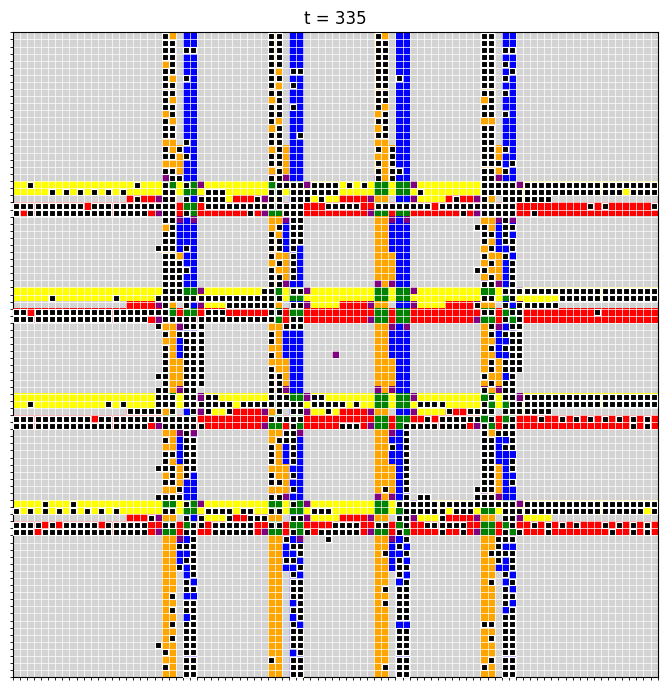

KeyboardInterrupt: 

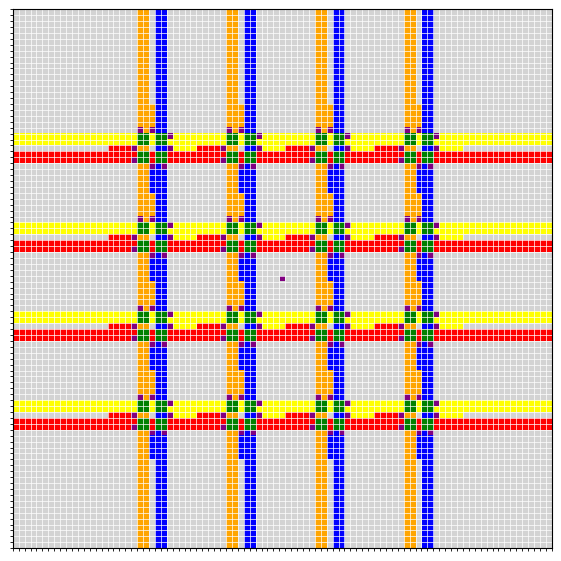

In [100]:
#seeded test
if __name__ == "__main__":
    random.seed(10)
    np.random.seed(10)
    totalsteps = 400
    board, cars, car_count, t_stop = run_sim_steps(n=91, timesteps=totalsteps, pause=0.01, initial_spawn=18, spawn_every=1, spawn_num=8, max_cars=10000, steps_per_draw=1, use_clear_output=True)

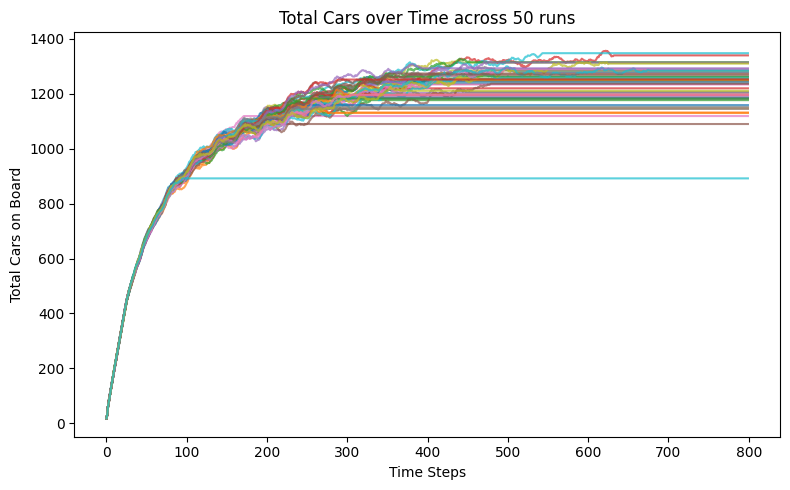

In [113]:
# --- parameters you already use ---
simsteps = 800
n = 81
initial_spawn = 18
spawn_every = 1
spawn_num = 32
max_cars = 10000
steps_per_draw = 1

num_runs = 50  # how many independent simulations

all_counts = []
stop_times = []

for run in range(1, num_runs + 1):
    # optional: different seeds per run for reproducibility
    random.seed(run)
    np.random.seed(run)

    sim_car_count, t_stop = calc_sim_steps(
        n=n, timesteps=simsteps, initial_spawn=initial_spawn,
        spawn_every=spawn_every, spawn_num=spawn_num,
        max_cars=max_cars, steps_per_draw=steps_per_draw
    )
    all_counts.append(sim_car_count)
    stop_times.append(t_stop)

# --- plotting all runs together ---
x = np.arange(0, simsteps, 1)

plt.figure(figsize=(8, 5))
for i, counts in enumerate(all_counts, start=1):
    # If a run ended early, pad to simsteps with the last value (or NaN)
    if len(counts) < simsteps:
        padded = counts + [counts[-1]] * (simsteps - len(counts))
        plt.plot(x, padded, alpha=0.7, label=f"Run {i} (stop t={stop_times[i-1]})")
    else:
        plt.plot(x, counts, alpha=0.7, label=f"Run {i}")

plt.xlabel("Time Steps")
plt.ylabel("Total Cars on Board")
plt.title(f"Total Cars over Time across {num_runs} runs")
plt.tight_layout()
plt.show()


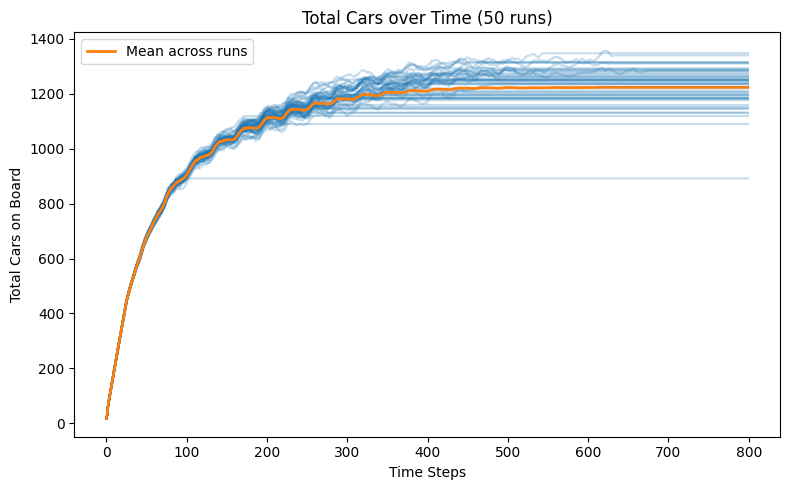

In [114]:

# Convert to a 2D array with consistent length
# (pad shorter runs with the last observed value)
def pad_to_length(lst, length):
    if len(lst) >= length:
        return lst[:length]
    return lst + [lst[-1]] * (length - len(lst))

padded_matrix = np.vstack([pad_to_length(counts, simsteps) for counts in all_counts])
mean_curve = padded_matrix.mean(axis=0)

plt.figure(figsize=(8, 5))
x = np.arange(simsteps)

# individual runs
for i, counts in enumerate(padded_matrix, start=1):
    plt.plot(x, counts, color="C0", alpha=0.25)

# average curve on top
plt.plot(x, mean_curve, color="C1", linewidth=2, label="Mean across runs")

plt.xlabel("Time Steps")
plt.ylabel("Total Cars on Board")
plt.title(f"Total Cars over Time ({num_runs} runs)")
plt.legend()
plt.tight_layout()
plt.show()
